In [ ]:
import os
import mne
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('../read_labels/v1.0.0/src')
import sys_tools.nedc_cmdl_parser as ncp
import sys_tools.nedc_file_tools as nft
import sys_tools.nedc_ann_tools as nat

# Load .edf

In [3]:
filepath = '../dataset/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/00007793_s001_t001.edf'
raw = mne.io.read_raw_edf(filepath)
raw.load_data()

Extracting EDF parameters from /media/windows/Users/Remy/OneDrive/Documents/Polycoco/dataset/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/00007793_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342749  =      0.000 ...  1370.996 secs...


<RawEDF | 00007793_s001_t001.edf, 36 x 342750 (1371.0 s), ~94.2 MB, data loaded>

# Get reference channels

In [4]:
raw.ch_names

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG ROC-REF',
 'EEG LOC-REF',
 'EEG EKG1-REF',
 'EMG-REF',
 'EEG 26-REF',
 'EEG 27-REF',
 'EEG 28-REF',
 'EEG 29-REF',
 'EEG 30-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'PHOTIC-REF',
 'IBI',
 'BURSTS',
 'SUPPR']

In [5]:
df_names = pd.read_csv('../dataset/_DOCS/montage_names', sep=' ', header=None)
df_names.columns = ['ch_id']
channels = {}
for i, id in enumerate(df_names['ch_id'],1):
    for j, name in enumerate(raw.ch_names):
        if ' '+id in name:
            channels[id] = j
            break

In [6]:
data = raw.get_data()

In [7]:
data.shape

(36, 342750)

In [8]:
data.dtype

dtype('float64')

# Combine channels

### Montage 1

In [9]:
montage1 = np.zeros((2, data.shape[1])).astype(data.dtype)
firstElec = ['FP1', 'F7', 'T3', 'T5', 'FP2', 'F8', 'T4', 'T6', 'A1', 'T3', 'C3', 'CZ', 'C4', 'T4', 'FP1',
             'F3', 'C3', 'P3', 'FP2', 'F4', 'C4', 'P4']
secondElec = ['F7', 'T3', 'T5', 'O1', 'F8', 'T4', 'T6', 'O2', 'T3', 'C3', 'CZ', 'C4', 'T4', 'A2', 'F3', 
              'C3', 'P3', 'O1', 'F4', 'C4', 'P4', 'O2']
combinations = zip(firstElec, secondElec)
montages = list(map(lambda elec1, elec2: data[channels[elec1],:] - data[channels[elec2],:], firstElec, secondElec))
montages_names = list(map(lambda elec1, elec2: elec1+'-'+elec2, firstElec, secondElec))

# Create new Raw objects

In [10]:
raws = list(map(lambda montage, name:
                        mne.io.RawArray(montage.reshape(1,-1),
                        info=mne.create_info([name], 
                                             raw.info['sfreq'])), 
                montages, montages_names))

Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749 =      0.000 ...  1370.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=342750
    Range : 0 ... 342749

# Load labels

In [11]:
import os

In [12]:
a=os.listdir('../dataset')[2]
os.path.splitext(a)

('_AAREADME', '.txt')

In [13]:
# Create mne.Annotations object
def make_mne_annotation(annotations):
    onset = []
    duration = []
    description = []
    for annotation in annotations:
        if 'seiz' in annotation[2].keys():
            onset.append(annotation[0])
            duration.append(annotation[1] - annotation[0])
            description.append('seiz')
    my_annot = mne.Annotations(onset=onset,
                               duration=duration,
                               description=description)
    return my_annot

In [14]:
filepath = '../dataset/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/00007793_s001_t001.lbl_bi' # See channel 4
ann = nat.Annotations()
status = ann.load(nft.get_fullpath(filepath))

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


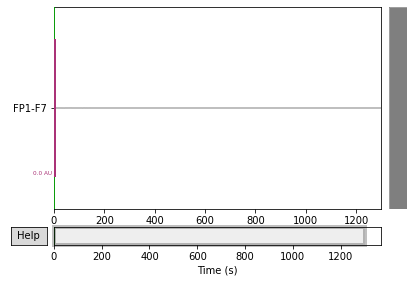

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


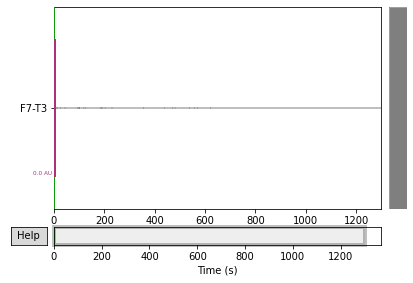

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


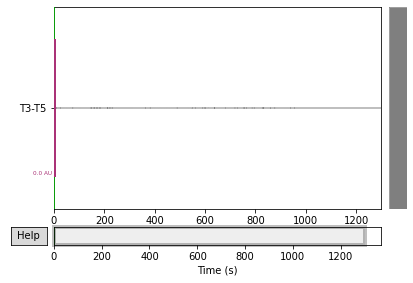

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


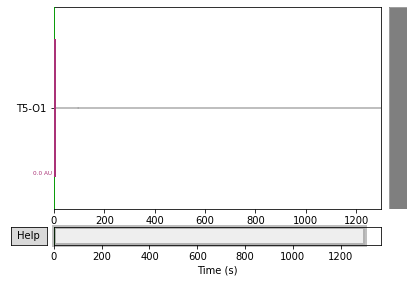

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 851.992, OrderedDict([('bckg', 1.0)])], [851.992, 909.012, OrderedDict([('seiz', 1.0)])], [909.012, 1371.0, OrderedDict([('bckg', 1.0)])]]


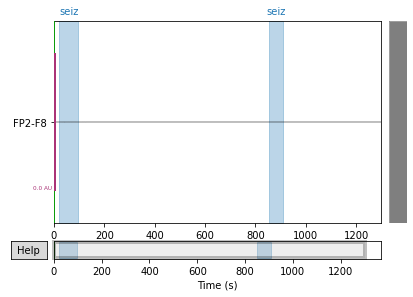

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 851.992, OrderedDict([('bckg', 1.0)])], [851.992, 909.012, OrderedDict([('seiz', 1.0)])], [909.012, 1371.0, OrderedDict([('bckg', 1.0)])]]


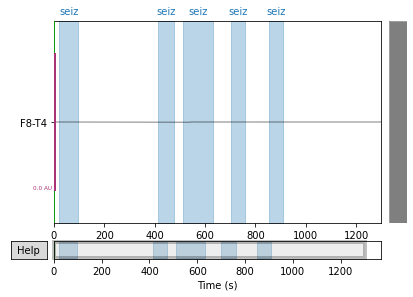

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 1371.0, OrderedDict([('bckg', 1.0)])]]


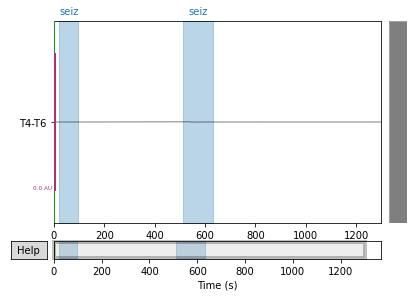

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


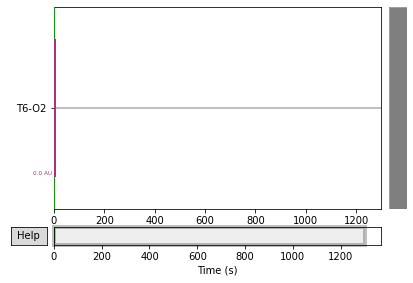

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


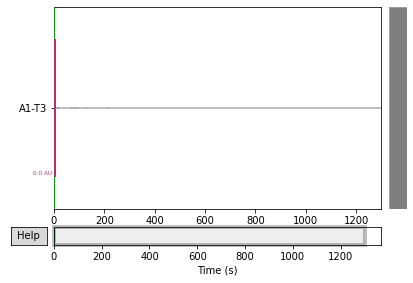

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


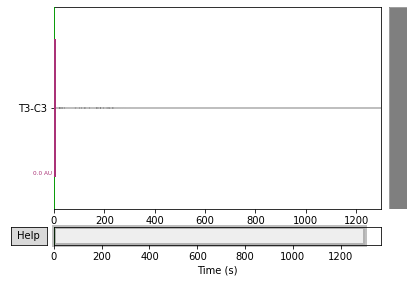

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 1371.0, OrderedDict([('bckg', 1.0)])]]


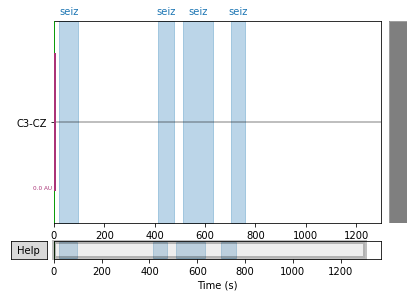

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 1371.0, OrderedDict([('bckg', 1.0)])]]


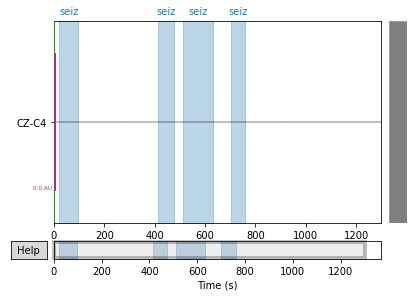

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 851.992, OrderedDict([('bckg', 1.0)])], [851.992, 909.012, OrderedDict([('seiz', 1.0)])], [909.012, 1371.0, OrderedDict([('bckg', 1.0)])]]


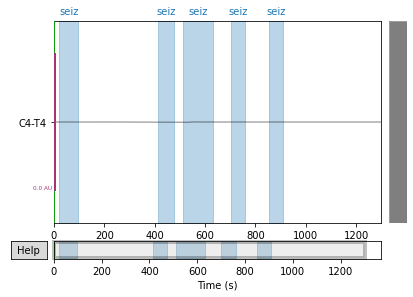

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 851.992, OrderedDict([('bckg', 1.0)])], [851.992, 909.012, OrderedDict([('seiz', 1.0)])], [909.012, 1371.0, OrderedDict([('bckg', 1.0)])]]


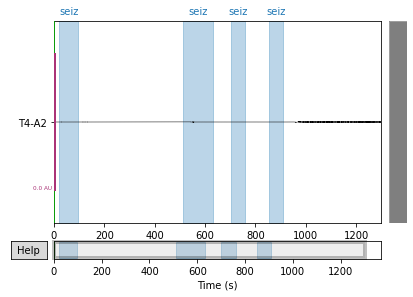

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


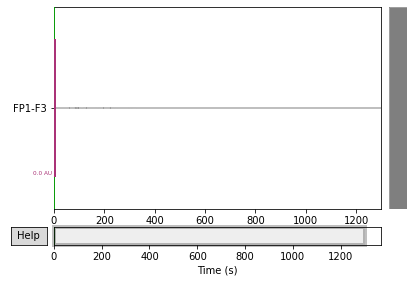

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


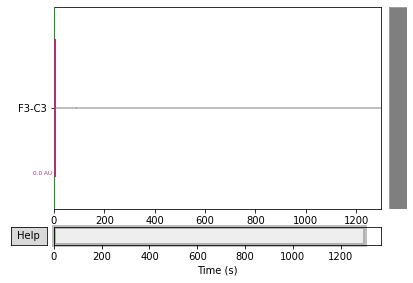

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


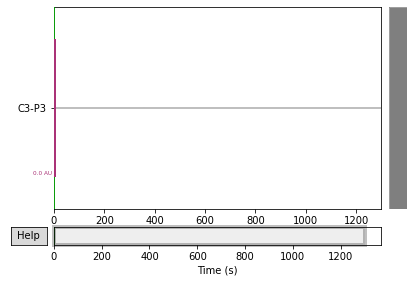

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


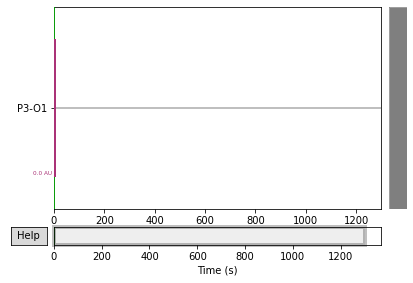

[[0.0, 1371.0, OrderedDict([('bckg', 1.0)])]]


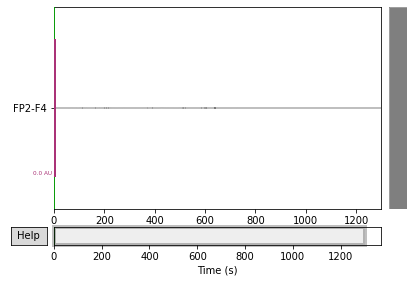

[[0.0, 19.84, OrderedDict([('bckg', 1.0)])], [19.84, 97.252, OrderedDict([('seiz', 1.0)])], [97.252, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 851.992, OrderedDict([('bckg', 1.0)])], [851.992, 909.012, OrderedDict([('seiz', 1.0)])], [909.012, 1371.0, OrderedDict([('bckg', 1.0)])]]


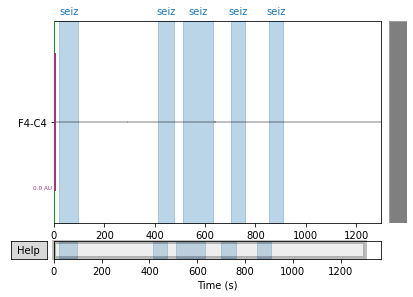

[[0.0, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 1371.0, OrderedDict([('bckg', 1.0)])]]


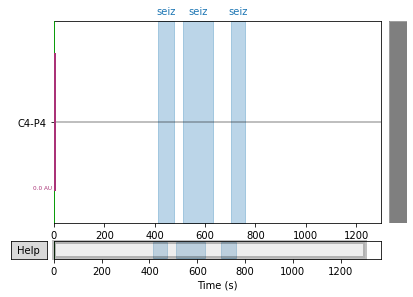

[[0.0, 413.044, OrderedDict([('bckg', 1.0)])], [413.044, 475.336, OrderedDict([('seiz', 1.0)])], [475.336, 511.904, OrderedDict([('bckg', 1.0)])], [511.904, 631.852, OrderedDict([('seiz', 1.0)])], [631.852, 700.952, OrderedDict([('bckg', 1.0)])], [700.952, 760.136, OrderedDict([('seiz', 1.0)])], [760.136, 1371.0, OrderedDict([('bckg', 1.0)])]]


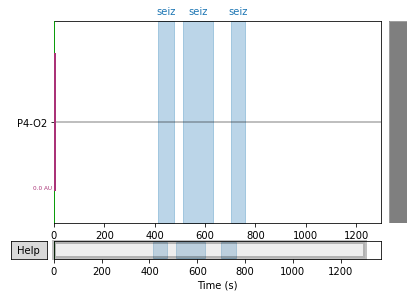

In [15]:
for i, r in enumerate(raws):
    print(ann.get(0,0,i))
    r.set_annotations(make_mne_annotation(ann.get(0,0,i)))
    r.plot(start=0, duration=1300, n_channels=3);